In [1]:
#|default_exp train

In [2]:
# !pip install -U transformers nbdev fastcore accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [3]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [4]:
#|export
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader
from functools import partial
from types import SimpleNamespace

from utils import pil_add_text, latent_to_PIL, make_grid, fmnist_labels, encode_prompt, dcae_scalingf, pil_clipscore, cifar10_labels, free_memory, mnist_labels

seed = 42
set_seed(seed)


In [5]:
#|export
def load_models(text_encoder, transformer_config, ae, dtype, device):
    transformer = SanaTransformer2DModel.from_config(transformer_config).to(device).to(dtype)
    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderDC.from_pretrained(ae, subfolder="vae", torch_dtype=dtype).to(device)

    if debug:
        print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
        print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

def load_data(repo_name, split_train="train", split_test="test", col_latent = "latent", col_label = "label"):
    print(f"loading dataset {repo_name}")
    
    ds = load_dataset(repo_name)
    for split in ds: 
        if not split in [split_train, split_test]: 
            del ds[split]
    latent_shape = torch.Tensor(ds[split_train][0][col_latent]).shape
    features = ds[split_train].features

    assert len(latent_shape)==4
    assert col_latent in features and col_label in features
    assert ds[split_train].features==ds[split_test].features

    if debug:
        for i, split in enumerate([split_train, split_test]): 
            print(f" split #{i} {split}: {len(ds[split])} samples, features: {[k for k in ds[split].features]}")
        print(f" latent shape {latent_shape}")

    return ds, latent_shape
    
def collate_(items, labels_encoded, col_latent = "latent", col_label = "label"):
    assert col_latent in items[0] and col_label in items[0]
    labels = [i[col_label] for i in items]
    latents = torch.cat([torch.Tensor(i[col_latent]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

def get_dataloader(dataset, batch_size, collate_fn):
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        generator = torch.manual_seed(seed), 
        collate_fn = collate_fn
    )
    if debug:
        print("dataset size", len(dataset))
        for i, col in enumerate(next(iter(dataloader))):
            coltype = type(col)
            collength = len(col) if coltype==list else col.shape
            print(f" col {i} {coltype.__name__} {collength}")
    return dataloader
    
def get_timesteps(num_steps):
    dt = 1.0 / num_steps
    timesteps = [int(i/num_steps*1000) for i in range(num_steps, 0, -1)]
    return dt, timesteps

def generate(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, latent_seed=None):
    assert latent_dim is not None
    dt, timesteps = get_timesteps(num_steps)
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator=torch.manual_seed(latent_seed) if latent_seed else None).to(dtype).to(device)
    for t in timesteps:
        t = torch.Tensor([t]).to(dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(latent, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latent = latent - dt * noise_pred

    return latent_to_PIL(latent / dcae_scalingf, dcae)

def add_random_noise(latents, timesteps=1000):
    noise_dist = train_config.timestep_sampling
    bs = latents.size(0)
    noise = torch.randn_like(latents)
    if noise_dist=="uniform":
        t = torch.randint(1, timesteps + 1, (bs,)).to(device)
        # t = torch.Tensor([900]*bs).to(torch.int64).to(device)
    elif noise_dist=="beta":
        beta = torch.distributions.beta.Beta(torch.tensor(1), torch.tensor(2.5))
        t = (beta.sample([bs])*timesteps).to(torch.int64).to(device)
    tperc = t.view([latents.size(0), *([1] * len(latents.shape[1:]))])/timesteps
    latents_noisy = (1 - tperc) * latents + tperc * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy, noise, t

def eval_loss(dataloader_eval, timesteps=1000, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss"):
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, timesteps)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        if testing: break
    return sum(losses)/len(losses)

In [6]:
#|export

data_config = SimpleNamespace(
    dataset = "g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0",
    labels_dict = fmnist_labels,
    col_label = "label",
    col_latent = "latent",
    split_train = "train",
    split_eval = "test",
)

train_config = SimpleNamespace(
    lr = 5e-4,
    bs = 2048,
    epochs = 20,
    steps_log = 10,
    steps_eval = 100,
    eval_prompts = [data_config.labels_dict[k] for k in data_config.labels_dict],
    eval_seeds = [6945, 4009, 1479, 8141, 3441], # seeds for latent generation
    eval_timesteps = 100, # number of timesteps for generating eval images
    timesteps_training = 1000,
    timestep_sampling = "beta",  # beta uniform
)

In [7]:
#|export

free_memory()

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
debug = True

log_wandb = True
wandb_project = "Hana"

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = "answerdotai/ModernBERT-base",
    transformer_config = "transformer_Sana-DiT-S-MBERT.json",
    ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers",
    dtype = dtype,
    device = device
)

ds, latent_shape = load_data(data_config.dataset)

collate_fn = partial(
    collate_, 
    labels_encoded = {
        k: encode_prompt(data_config.labels_dict[k], tokenizer, text_encoder) 
        for k in data_config.labels_dict
    }
)
dataloader_train = get_dataloader(ds[data_config.split_train], train_config.bs, collate_fn)
dataloader_eval =  get_dataloader(ds[data_config.split_eval], train_config.bs, collate_fn)
# eval_prompts = [labels[k] for k in labels]

optimizer = torch.optim.AdamW(transformer.parameters(), lr=train_config.lr)

wandb_run = "Sana-DiT-S-{size:.2f}M_{ds}_LR-{lr}_BS-{bs}_{ts_sampling}-TS-{ts}_{device}".format(
    size=sum(p.numel() for p in transformer.parameters())/1e6, 
    lr=train_config.lr, 
    bs=train_config.bs, 
    ts=train_config.timesteps_training,
    ts_sampling=train_config.timestep_sampling.upper(),
    device=device,
    ds=data_config.dataset.split("/")[1].split("-")[0]
)

steps_epoch = len(dataloader_train)
print(f"steps per epoch: {steps_epoch}")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Transformer parameters: 17.78M
DCAE parameters: 312.25M
loading dataset g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0
 split #0 train: 60000 samples, features: ['label', 'latent']
 split #1 test: 10000 samples, features: ['label', 'latent']
 latent shape torch.Size([1, 32, 2, 2])
dataset size 60000
 col 0 list 2048
 col 1 Tensor torch.Size([2048, 32, 2, 2])
 col 2 Tensor torch.Size([2048, 300, 768])
 col 3 Tensor torch.Size([2048, 300])
dataset size 10000
 col 0 list 2048
 col 1 Tensor torch.Size([2048, 32, 2, 2])
 col 2 Tensor torch.Size([2048, 300, 768])
 col 3 Tensor torch.Size([2048, 300])
steps per epoch: 30


Eval prompts:
[(0, 'T-shirt/top'), (1, 'Trouser'), (2, 'Pullover'), (3, 'Dress'), (4, 'Coat'), (5, 'Sandal'), (6, 'Shirt'), (7, 'Sneaker'), (8, 'Bag'), (9, 'Ankle boot')]
Inspecting first batch


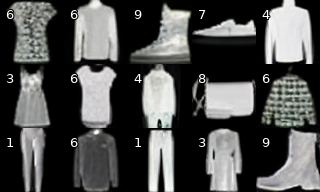

Testing generate


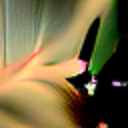

Testing eval loss


eval_loss: 0it [00:01, ?it/s]


2.96875
Testing eval images and clip score


eval_images: 100%|██████████████████████████████| 10/10 [00:01<00:00,  5.24it/s]


22.47494125366211


In [8]:
print("Eval prompts:")
print(list(enumerate(train_config.eval_prompts)))

print("Inspecting first batch")
def show_first_batch(dataloader):
    labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
    images = [pil_add_text(latent_to_PIL(latent[None, :], dcae), str(label)) for label, latent in zip(labels[:20], latents[:20])]
    display(make_grid(images[:15], 3, 5))
show_first_batch(dataloader_train)

print("Testing generate")
display(generate("horse", tokenizer, text_encoder, num_steps=10, latent_dim=latent_shape).resize((128,128)))

print("Testing eval loss")
print(eval_loss(dataloader_eval, testing=True))

print("Testing eval images and clip score")
images = [
    generate(p, tokenizer, text_encoder, latent_dim=latent_shape, num_steps=10) 
    for p in tqdm(train_config.eval_prompts, "eval_images")
]
print(pil_clipscore(images, train_config.eval_prompts))

# Train

In [9]:
import nbdev; nbdev.export.nb_export(__session__)

In [ ]:
#|export

if log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(project=wandb_project, name=wandb_run).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()
free_memory()

for _ in range(train_config.epochs):
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader_train:
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents)
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
        loss = F.mse_loss(noise_pred, noise - latents)
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()    
        
        if step>0 and step % train_config.steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / train_config.steps_log * 1000
            sample_tp = train_config.bs * train_config.steps_log / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.4f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if log_wandb: wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": step * train_config.bs, "epoch": step / steps_epoch})
            last_step_time = time.time()

        if step % train_config.steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(dataloader_eval)

            # try different seeds for generating eval images
            images_eval = [
                generate(p, tokenizer, text_encoder, num_steps=train_config.eval_timesteps, latent_dim=latent_shape, latent_seed=seed) 
                for seed in tqdm(train_config.eval_seeds, "eval_images")
                for p in train_config.eval_prompts
            ]
            clipscore = pil_clipscore(images_eval, train_config.eval_prompts * len(train_config.eval_seeds))
            # add labels before logging the images
            images_eval = make_grid([
                pil_add_text(img, train_config.eval_prompts[i % len(train_config.eval_prompts)]) 
                for i, img in enumerate(images_eval)
            ], rows=len(train_config.eval_seeds), cols=len(train_config.eval_prompts))
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if log_wandb: wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": step * train_config.bs, "epoch": step / steps_epoch})
            else: display(make_grid(images_eval, 2, 5))
            transformer.train()        

        step += 1

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


eval_loss: 5it [00:06,  1.39s/it]
eval_images: 100%|████████████████████████████████| 5/5 [01:22<00:00, 16.46s/it]


step 0, eval loss: 3.2313, clipscore: 21.79
step 10, epoch: 0.3333, train loss: 1.6406, grad_norm: 1.04, 12279.98ms/step, 166.78samples/sec
step 20, epoch: 0.6667, train loss: 1.4375, grad_norm: 0.45, 1712.31ms/step, 1196.05samples/sec
step 30, epoch: 1.0000, train loss: 1.3516, grad_norm: 0.40, 1560.92ms/step, 1312.05samples/sec
step 40, epoch: 1.3333, train loss: 1.2969, grad_norm: 0.30, 1531.79ms/step, 1337.00samples/sec
step 100, epoch: 3.3333, train loss: 1.0000, grad_norm: 0.55, 1752.10ms/step, 1168.89samples/sec


eval_loss: 5it [00:08,  1.67s/it]
eval_images: 100%|████████████████████████████████| 5/5 [01:14<00:00, 14.91s/it]


step 100, eval loss: 0.9961, clipscore: 23.93
step 110, epoch: 3.6667, train loss: 0.9844, grad_norm: 0.44, 10980.71ms/step, 186.51samples/sec
step 120, epoch: 4.0000, train loss: 0.9648, grad_norm: 0.49, 1416.74ms/step, 1445.57samples/sec
step 130, epoch: 4.3333, train loss: 0.9531, grad_norm: 0.51, 1774.85ms/step, 1153.90samples/sec
step 140, epoch: 4.6667, train loss: 0.9375, grad_norm: 0.40, 1711.43ms/step, 1196.66samples/sec
step 150, epoch: 5.0000, train loss: 0.9336, grad_norm: 0.44, 1708.55ms/step, 1198.68samples/sec
step 160, epoch: 5.3333, train loss: 0.9414, grad_norm: 0.35, 1705.53ms/step, 1200.80samples/sec
step 170, epoch: 5.6667, train loss: 0.9258, grad_norm: 0.34, 1734.85ms/step, 1180.51samples/sec
step 180, epoch: 6.0000, train loss: 0.9297, grad_norm: 0.52, 1596.29ms/step, 1282.97samples/sec
step 190, epoch: 6.3333, train loss: 0.9180, grad_norm: 0.38, 1570.87ms/step, 1303.74samples/sec
step 200, epoch: 6.6667, train loss: 0.9062, grad_norm: 0.38, 1490.78ms/step, 137

eval_loss: 5it [00:07,  1.44s/it]
eval_images: 100%|████████████████████████████████| 5/5 [01:14<00:00, 14.99s/it]


step 200, eval loss: 0.9117, clipscore: 25.68
step 210, epoch: 7.0000, train loss: 0.9141, grad_norm: 0.50, 10981.36ms/step, 186.50samples/sec
step 220, epoch: 7.3333, train loss: 0.9102, grad_norm: 0.51, 1509.13ms/step, 1357.08samples/sec
step 230, epoch: 7.6667, train loss: 0.8984, grad_norm: 0.41, 1501.52ms/step, 1363.95samples/sec
step 240, epoch: 8.0000, train loss: 0.8984, grad_norm: 0.36, 1375.46ms/step, 1488.96samples/sec
step 250, epoch: 8.3333, train loss: 0.8867, grad_norm: 0.32, 1451.57ms/step, 1410.88samples/sec
step 260, epoch: 8.6667, train loss: 0.8945, grad_norm: 0.31, 1707.15ms/step, 1199.66samples/sec
step 270, epoch: 9.0000, train loss: 0.9375, grad_norm: 1.34, 1383.16ms/step, 1480.67samples/sec
step 280, epoch: 9.3333, train loss: 0.8984, grad_norm: 0.40, 1535.57ms/step, 1333.70samples/sec
step 290, epoch: 9.6667, train loss: 0.9023, grad_norm: 0.30, 1646.26ms/step, 1244.03samples/sec
step 300, epoch: 10.0000, train loss: 0.8867, grad_norm: 0.35, 1588.66ms/step, 12

eval_loss: 5it [00:07,  1.42s/it]
eval_images: 100%|████████████████████████████████| 5/5 [01:14<00:00, 14.98s/it]


step 300, eval loss: 0.8867, clipscore: 25.64
step 310, epoch: 10.3333, train loss: 0.8867, grad_norm: 0.27, 11160.33ms/step, 183.51samples/sec
step 320, epoch: 10.6667, train loss: 0.8750, grad_norm: 0.31, 1738.12ms/step, 1178.28samples/sec
step 330, epoch: 11.0000, train loss: 0.8711, grad_norm: 0.32, 1524.30ms/step, 1343.57samples/sec
step 340, epoch: 11.3333, train loss: 0.8711, grad_norm: 0.33, 1509.25ms/step, 1356.97samples/sec
step 350, epoch: 11.6667, train loss: 0.8750, grad_norm: 0.32, 1537.41ms/step, 1332.11samples/sec
step 360, epoch: 12.0000, train loss: 0.8750, grad_norm: 0.36, 1521.68ms/step, 1345.88samples/sec
step 370, epoch: 12.3333, train loss: 0.8711, grad_norm: 0.33, 1511.24ms/step, 1355.17samples/sec
step 380, epoch: 12.6667, train loss: 0.8633, grad_norm: 0.29, 1575.91ms/step, 1299.57samples/sec
step 390, epoch: 13.0000, train loss: 0.8633, grad_norm: 0.37, 1402.57ms/step, 1460.18samples/sec
step 400, epoch: 13.3333, train loss: 0.8633, grad_norm: 0.29, 1465.62ms

eval_loss: 5it [00:07,  1.41s/it]
eval_images: 100%|████████████████████████████████| 5/5 [01:15<00:00, 15.04s/it]


step 400, eval loss: 0.8711, clipscore: 26.38
step 410, epoch: 13.6667, train loss: 0.8672, grad_norm: 0.29, 11215.98ms/step, 182.60samples/sec
step 420, epoch: 14.0000, train loss: 0.8594, grad_norm: 0.47, 1604.25ms/step, 1276.61samples/sec
step 430, epoch: 14.3333, train loss: 0.8594, grad_norm: 0.32, 1670.61ms/step, 1225.90samples/sec
step 440, epoch: 14.6667, train loss: 0.8477, grad_norm: 0.33, 1542.74ms/step, 1327.50samples/sec
step 450, epoch: 15.0000, train loss: 0.8477, grad_norm: 0.33, 1364.15ms/step, 1501.30samples/sec
step 460, epoch: 15.3333, train loss: 0.8633, grad_norm: 0.29, 1513.39ms/step, 1353.25samples/sec
step 470, epoch: 15.6667, train loss: 0.8555, grad_norm: 0.29, 1629.67ms/step, 1256.70samples/sec
step 480, epoch: 16.0000, train loss: 0.8594, grad_norm: 0.38, 1469.88ms/step, 1393.32samples/sec
step 490, epoch: 16.3333, train loss: 0.8594, grad_norm: 0.36, 1509.35ms/step, 1356.87samples/sec
step 500, epoch: 16.6667, train loss: 0.8438, grad_norm: 0.26, 1709.74ms

eval_loss: 5it [00:07,  1.55s/it]
eval_images: 100%|████████████████████████████████| 5/5 [01:13<00:00, 14.69s/it]


step 500, eval loss: 0.8617, clipscore: 26.01
step 510, epoch: 17.0000, train loss: 0.8555, grad_norm: 0.38, 10771.08ms/step, 190.14samples/sec
step 520, epoch: 17.3333, train loss: 0.8516, grad_norm: 0.37, 1732.69ms/step, 1181.97samples/sec
step 530, epoch: 17.6667, train loss: 0.8438, grad_norm: 0.31, 1734.68ms/step, 1180.62samples/sec
step 540, epoch: 18.0000, train loss: 0.8438, grad_norm: 0.30, 1630.83ms/step, 1255.80samples/sec
step 550, epoch: 18.3333, train loss: 0.8398, grad_norm: 0.29, 1662.44ms/step, 1231.92samples/sec
step 560, epoch: 18.6667, train loss: 0.8477, grad_norm: 0.26, 1525.12ms/step, 1342.85samples/sec
step 570, epoch: 19.0000, train loss: 0.8438, grad_norm: 0.31, 1399.61ms/step, 1463.26samples/sec
step 580, epoch: 19.3333, train loss: 0.8398, grad_norm: 0.29, 1523.02ms/step, 1344.69samples/sec
step 590, epoch: 19.6667, train loss: 0.8555, grad_norm: 0.29, 1549.58ms/step, 1321.65samples/sec
step 600, epoch: 20.0000, train loss: 0.8438, grad_norm: 0.35, 1364.96ms

eval_loss: 5it [00:06,  1.40s/it]
eval_images:  80%|█████████████████████████▌      | 4/5 [00:57<00:14, 14.24s/it]

In [ ]:
# transformer.push_to_hub(f"g-ronimo/hana-alpha17")

In [ ]:
#|export

# # THE GALLERY!
# gallery_rows = []
# num_samples = 10
# for prompt in tqdm(eval_prompts, prompt):
#     row = make_grid([
#         generate(prompt, tokenizer, text_encoder, num_steps=100, latent_dim=latent_shape) 
#         for i in range(num_samples)
#     ], 1, num_samples)
#     row = pil_add_text(row, prompt, position=(1,1))
#     gallery_rows.append(row)
# make_grid(gallery_rows, 10, 1)